<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/assign_4/assign_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

shapes3d: https://www.tensorflow.org/datasets/catalog/shapes3d

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(42)

In [2]:
import tensorflow_datasets as tfds

In [3]:
info = tfds.builder('shapes3d').info

In [4]:
#info

In [5]:
total = info.splits['train'].num_examples
# take 30% of data
take_data = int(0.3 * total)
train_dataset = tfds.load('shapes3d', split=f'train[:{take_data}]')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/480000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/shapes3d/incomplete.HBRPOI_2.0.0/shapes3d-train.tfrecord*...:   0%|       …

Dataset shapes3d downloaded and prepared to /root/tensorflow_datasets/shapes3d/2.0.0. Subsequent calls will reuse this data.


In [6]:
take_data

144000

In [7]:
def preprocess_data(data):
    image = tf.cast(data['image'], tf.float32) / 255.0
    return image

In [8]:
train_dataset = train_dataset.map(preprocess_data)
train_dataset = train_dataset.batch(batch_size=32)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

## Variational Autoencoder

In [9]:
# https://www.tensorflow.org/tutorials/generative/cvae#network_architecture

class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim=2):
        """
        latent_dim: int, typically much smaller than the original input dimension and represent the compressed, encoded version of the data.
        """
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
                # 4 layers
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
                ),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
                ),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
                ),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
                ),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=8 * 8 * 32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=2,
                    padding="same",
                    activation="relu",
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=2,
                    padding="same",
                    activation="relu",
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=2,
                    padding="same",
                    activation="relu",
                ),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=1, padding="same"
                ),
            ]
        )

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    @tf.function
    def sample(self, z=None):
        if z is None:
            z = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(z, apply_sigmoid=True)

    def train_step(self, data):
        # Access the images using indexing
        images = data
        with tf.GradientTape() as tape:
            mean, logvar = self.encode(images)
            z = self.reparameterize(mean, logvar)
            reconstruction = self.decode(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(images, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Train Model

In [10]:
cvae = CVAE()
cvae.compile(optimizer=tf.keras.optimizers.Adam())

In [11]:
cvae.fit(train_dataset, epochs=10)

Epoch 1/10
4500/4500 [==============================] - 1468s 325ms/step - loss: 2453.2027 - reconstruction_loss: 1992.9222 - kl_loss: 9.1625
Epoch 2/10
4500/4500 [==============================] - 1463s 325ms/step - loss: 1608.7423 - reconstruction_loss: 1593.5940 - kl_loss: 8.6402
Epoch 3/10
4500/4500 [==============================] - 1489s 331ms/step - loss: 1553.0879 - reconstruction_loss: 1551.9147 - kl_loss: 8.4452
Epoch 4/10
4500/4500 [==============================] - 1518s 337ms/step - loss: 1557.0351 - reconstruction_loss: 1543.0634 - kl_loss: 8.5008
Epoch 5/10
4500/4500 [==============================] - 1510s 336ms/step - loss: 1538.6822 - reconstruction_loss: 1533.1483 - kl_loss: 8.6532
Epoch 6/10
4500/4500 [==============================] - 1493s 332ms/step - loss: 1525.4268 - reconstruction_loss: 1525.3635 - kl_loss: 8.8411
Epoch 7/10
4500/4500 [==============================] - 1481s 329ms/step - loss: 1549.9110 - reconstruction_loss: 1534.5833 - kl_loss: 9.0463
Epoch 

## Show 2D manifolds of the code

In [12]:
import tensorflow_probability as tfp

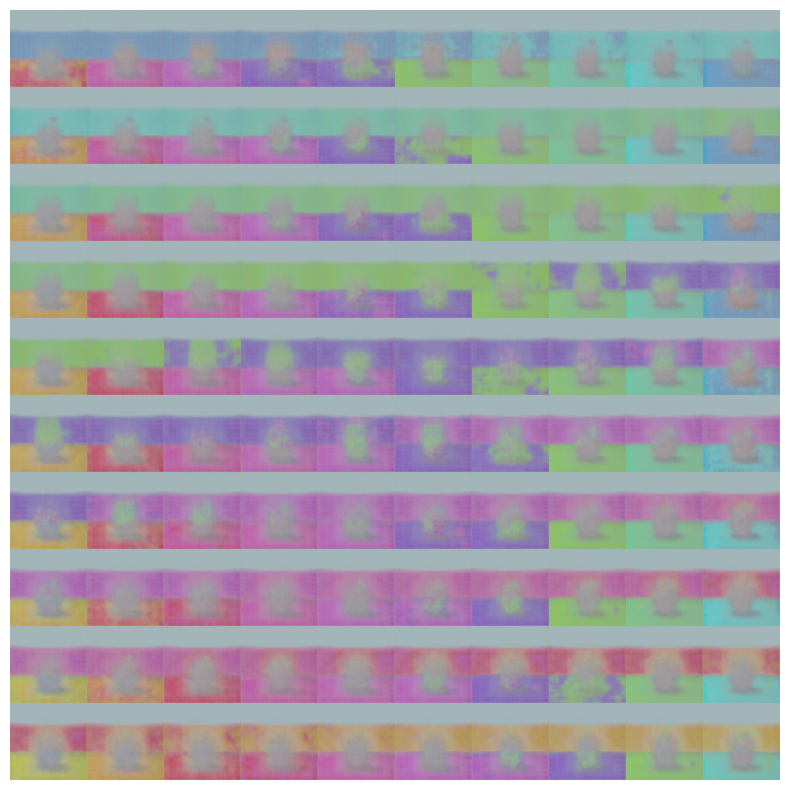

In [26]:
def plot_latent_images(model, n, digit_size=64):
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width, 3))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit_rgb = tf.image.resize(x_decoded[0], (digit_size, digit_size))
            digit_rgb = tf.clip_by_value(digit_rgb, 0.0, 1.0)
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit_rgb.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('Off')
    plt.show()

plot_latent_images(cvae, 10)